# **Lab Assignment 2**
🎯**Objective:** Calculate electronic / phonon density of states and band structure.

---
# Import and Initialization
---

## **General Workflow**
✅1) **Import and Initialization**
- To begin with, let's import the essential (for this assignment) libraries.
- Fill the parameter **struc** name. The file with **struc** name will be created and all calculations will be saved there. 
- Other cells must be run without any changes.
- For the first time you need to fill **struc**. But in the next times, when you will use this notebook, you can just completely run all cells in part *Import and Initialization* without any changes.

## Library

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import re
from ase.io.vasp import read_vasp_out, write_vasp, read_vasp_xml
from ase.io import write, read
from ase.calculators.vasp import Vasp
from ase.geometry import cell_to_cellpar
from ase.build import make_supercell, graphene
from ase import Atoms, Atom
from ase.io.lammpsdata import read_lammps_data
from ase.units import GPa
from calorine.calculators import CPUNEP, GPUNEP
from calorine.tools import relax_structure
from PIL import Image

from mendeleev import element
from pymatgen.io.vasp import Vasprun
from pymatgen.core.structure import Structure
from pymatgen.electronic_structure.core import Spin
from ase.calculators.espresso import Espresso, EspressoProfile
#from pymatgen.io.espresso.outputs import PWxml

import time
import yaml
import pickle
import json
from munch import Munch
from yaml import CLoader as Loader

import sys
sys.path.append("/home/heimao/Desktop/Khasan/python_files")
from util_functions import *

from threading import Thread
from multiprocessing import Pool, Process
from collections import defaultdict
import shutil
from pathlib import Path, PurePath

pd.options.plotting.backend = "plotly"

> **IMPORTANT**

> Insert **YOUR STRUCTURE NAME** file that will be used further. All calculations will be saved there.

In [ ]:
# Insert structure name
struc = 'Diamane' # Diamane

## MAIN DIRECTORY

In [ ]:
main_dir = create_folder(main_dir=Path(os.getcwd()), folder='Lab_works')
if main_dir.exists():
    print('Main Directory:')
    print(main_dir)
else:
    print('Directory does not exists')

Folder Lab_works already exists
Main Directory:
/home/heimao/Desktop/Khasan/Lab_works


## Import Working Directories

Load

In [5]:
general_paths_dir = create_folder(main_dir=main_dir, folder='utils') / 'general_paths.yaml'

if os.path.exists(general_paths_dir):
    with (general_paths_dir).open(mode='rb') as f:
        general_paths = dict_to_munch(yaml.unsafe_load(f))
        f.close()
else:
    general_paths = Munch()

# Create Others name key in pathes
if 'Others' not in general_paths.keys():
    general_paths['utils'] = Munch()
    general_paths['utils']['__val__'] = main_dir / 'utils'

# Create structure name key in pathes
if struc not in general_paths.keys():
    general_paths[struc] = Munch()
    general_paths[struc]['__val__'] = create_folder(main_dir=main_dir, folder=struc)

Folder utils already exists


Create working directories and save them

In [6]:
save_path(
    main_dir=create_folder(main_dir=general_paths[struc].__val__, folder='2.Electron_Phonon_props'), 
    dir_name='electron_phonon',
    general_paths_dir=general_paths_dir,
    munch_dict=general_paths[struc],
    general_dict=general_paths,
    )

save_path(
        main_dir=create_folder(main_dir=general_paths[struc].electron_phonon.__val__, folder='2.1.Electron_props'),
        dir_name='electron_props',
        general_paths_dir=general_paths_dir,
        munch_dict=general_paths[struc]['electron_phonon'],
        general_dict=general_paths,
        )

save_path(
        main_dir=create_folder(main_dir=general_paths[struc].electron_phonon.__val__, folder='2.2.Phonon_props'),
        dir_name='phonon_props',
        general_paths_dir=general_paths_dir,
        munch_dict=general_paths[struc]['electron_phonon'],
        general_dict=general_paths,
        )

# with (general_paths_dir).open(mode='w') as f:
#     yaml.dump(munch_to_dict(general_paths), f)
#     f.close()

Folder 2.Electron_Phonon_props already exists
File path is saved
Folder 2.1.Electron_props already exists
File path is saved
Folder 2.2.Phonon_props already exists
File path is saved


---
# PART 2 - Material properties
---

## Functions and Files

### **General Workflow**
✅2) **Initialize functions and download essential files**
- Mentioned below functions will be used for general calculation of some parameters. In most cases, they **DO NOT** need to change.

> **IMPORTANT** Please, check **POSCAR** and **PSEUDOPOTENTIALS** in the **UTILS** directory. <br>

- There is no need to add the code, just run the cells

In [ ]:
def create_dos_in(
    main_dir: str,
    prefix: str,
    deltaE: float,
    
): 
    with main_dir.open(mode='w') as f:
        f.write('&dos\n')
        f.write(f'prefix={prefix}\n')
        f.write(f"outdir = '.'\n")
        f.write(f'DeltaE = {deltaE}\n')
        f.write('/\n')

def dos_vals(work_dir: str, fn: str):
    with (work_dir / fn).open(mode='r+') as f:
        lines = f.readlines()
        # Fermi Energy
        FermiE = float(lines[0].split(' ')[-2])
        # Calculation DOS points
        Energy = np.zeros(len(lines)-1)
        DOS_E = np.zeros_like(Energy)
        for i, line in enumerate(lines[1:]):
            Energy[i] = float(list(filter(None, line.split(' ')))[0])
            DOS_E[i] = float(list(filter(None, line.split(' ')))[1])
        f.close()
    return FermiE, Energy, DOS_E

def band_gap(energy: np.array, dos: np.array, e_trs: float) -> int:
    assert len(energy) == len(dos)
    for i, E in enumerate(dos[energy>0]):
        if E > e_trs:
            break

    for j, E in enumerate(dos[energy<0][::-1]):
        if E > e_trs:
            break
    return energy[energy>0][i] + np.abs(energy[energy<0][::-1][j])

def create_bands_in(
    main_dir: str,
    prefix: str,
): 
    with main_dir.open(mode='w') as f:
        f.write('&bands\n')
        f.write(f'prefix={prefix}\n')
        f.write(f"outdir = '.'\n")
        f.write('/\n')

def bands_vals(work_dir: str):
    HSPoints = []
    bands_Energy = []

    with open(work_dir) as f:
        for line in f:
            vals = list(filter(None, line.strip().split(' ')))
            if len(vals):
                HSPoints.append( float(vals[0]) )
                bands_Energy.append( float(vals[1]) )
        f.close()
    return np.array(HSPoints), np.array(bands_Energy)

def get_q_distances(q_positions):
    diffs = np.linalg.norm(np.diff(q_positions, axis=0), axis=1)
    distances = np.concatenate(([0.0], np.cumsum(diffs)))
    return distances

def find_dist_for_hsp(
        bandpath: str,
        special_points: dict,
        path_kpts: np.array,
        hspoints: np.array,
):
    used_idx = set()
    hsp_dist = []
    for letter in bandpath:
        target = special_points[letter]
        dist = np.linalg.norm(path_kpts - target, axis=1)
        matches = np.where(dist < 10e-3)[0]
        matched_idx = np.sort([idx for idx in matches if idx not in used_idx])[0]
        used_idx.add(matched_idx)
        hsp_dist.append(hspoints[matched_idx])
    return hsp_dist

def create_phdos_files(
        main_dir: Path, 
        struc: str, 
        amass: list, 
        nq: list, 
        zasr: str, 
        nk: list, 
        epsil: str, 
        raman_spec: str, 
        IR_spec: str, 
        hsp_kpts: list
        ):
    with (main_dir / f"{struc}_ph.in").open(mode='w') as f:
        f.write("Phonon Calculation\n")
        f.write("&INPUTPH\n")
        f.write(f"  outdir = '.'\n")
        f.write(f"  prefix = '{struc}'\n")
        f.write(f"  tr2_ph = 1.0d-8\n")
        f.write(f"  ldisp = .true.\n")
        f.write(f"  verbosity = high\n")

        for i, mass in enumerate(amass):
               f.write(f"  amass({i+1}) = {np.round(mass, 3)}\n")

        f.write(f"  nq1 = {nq[0]}, nq2 = {nq[1]}, nq3 = {nq[2]}\n")
        f.write(f'  epsil = {epsil}\n')
        f.write(f'  trans = {raman_spec}\n')
        f.write(f'  elop = {IR_spec}\n')
        f.write(f'  reduce_io = .true.\n')
        f.write(f"  fildyn = '{struc}.dyn'\n/\n")
        f.close()
    
    with (main_dir / f"{struc}_q2r.in").open(mode='w') as f:
        f.write("&INPUT\n")
        f.write(f"  fildyn = '{struc}.dyn'\n")
        f.write(f"  zasr = '{zasr}'\n")
        f.write(f"  flfrc = {struc}_k{nq[0]}.fc\n/\n")
        f.close()
    
    with (main_dir / f"{struc}_matdyn_DOS.in").open(mode='w') as f:
        f.write("&INPUT\n")
        f.write(f"  asr = '{zasr}'\n")
        f.write(f"  flfrc = {struc}_k{nq[0]}.fc\n")
        f.write(f"  flfrq = {struc}.phdos.freq\n")
        f.write(f"  flvec = {struc}.phdos.modes\n")
        f.write(f"  dos = .true.\n")
        f.write(f"  fldos = {struc}.phdos\n")
        f.write(f"  nk1 = {nk[0]}, nk2 = {nk[1]}, nk3 = {nk[2]}\n/\n")
        f.close()
    
    with (main_dir / f"{struc}_matdyn_dispersion.in").open(mode='w') as f:
        f.write("&INPUT\n")
        f.write(f"  asr = '{zasr}'\n")

        for i, mass in enumerate(amass):
               f.write(f"  amass({i+1}) = {mass}\n")

        f.write(f"  flfrc = {struc}_k{nq[0]}.fc\n")
        f.write(f"  flfrq = {struc}.freq\n")
        f.write(f"  flvec = {struc}.modes\n")
        f.write(f"  q_in_band_form = .true.\n")
        f.write(f"  q_in_cryst_coord = .true.\n/\n")
        f.write(f"{len(hsp_kpts)}\n")

        for kpts in hsp_kpts:
            f.write(f"{kpts[0]} {kpts[1]} {kpts[2]} {kpts[3]} \n")
        f.close()
        
command = 'sh qe_run.sh'


**QE-run.sh**

In [ ]:
%%writefile {general_paths[struc].electron_phonon.__val__ / 'qe_run.sh'}
#!/bin/bash

mpirun -n 20 pw.x < espresso.pwi > espresso.pwo

## PART 2.1 - Electronic properties

### **General Workflow**
✅3) **Implement SCF & NSCF calculations and obtain electronic DOS**
- Firstly, you need to fill the function **get_scf_params** (you can find it in the cell below) by parameters for your structure. This function will be used for initialization of the input file for SCF calculation. The mentioned parameters in the function are used as example. You can add/remove some of them.

> **IMPORTANT** Please, copy SCF parameters from the previous lab with optimized **cutoff_energy** and **kpts** in the cell below. <br>

- You need correctly calculate **nbnd** number of bands for your structure. Number of bands will equal to the number of valence electrons in each atom. <br>
Example for my structure with 4 carbon atoms and 2 flourine atoms: <br>
nbnd = 4 * 4(valence electrons in C) + 2 * 7(valence electrons in F) = 30

- After fulfilling above mentioned parameters, please, run the cells in the part *SCF & NSCF Calculations*

- After implementation above steps, please, go to the working directory in the **Terminal**: <br>

📝Desktop/*your_name*/Lab_works/*struc*/2.Electron_Phonon_props/2.1.Electron_props <br>

🌟Run calculations: 
**sbatch dos_script.sh** <br>
If calculations successfully finished, you will see the note **JOB DONE** in the **espresso.pwo** files. If it is done, you can go to the next step.

- Please, run the cells in the part *DOS Calculation* and then go to the working directory in the **Terminal**: <br>

📝Desktop/*your_name*/Lab_works/*struc*/2.Electron_Phonon_props/2.1.Electron_props/DOS <br>

🌟Run calculations: 
**sbatch dos_in_script.sh** <br>
If calculations successfully finished, you will see the created file ***your_struc*.dos**

- In the visualisation part, you need run cells and obtain the figure. This figure must be used in your **Lab Report**

✅4) **Implement SCF calculation and obtain electronic BAND structure** <br>
- Firstly, you need to fill the function **get_scf_params** by parameters optimized **cutoff_energy** and **kpts**. <br>

- Also copy **nbnd** value from previous step. <br>

- The important parameters are **bandpath** and **special_points** that describe the line connecting high-symmetry points within the first Brillouin zone. You need to specify letters of high symmetry points in **bandpath** and its coordinates in **special_points**
> Choose High Symmetry Points for your material. You can find here: <br>
https://arxiv.org/pdf/1004.2974

- After implementation above steps, run the cells in the part *BANDS Calculation* and go to the working directory in the **Terminal**: <br>

📝Desktop/*your_name*/Lab_works/*struc*/2.Electron_Phonon_props/2.1.Electron_props <br>

🌟Run calculations: 
**sbatch bands_script.sh** <br>
If calculations successfully finished, you will see the note **JOB DONE** in the **espresso.pwo** files. If it is done, you can go to the next step.

- Please, run the cells in the part *BANDS Calculation* and then go to the working directory in the **Terminal**: <br>

📝Desktop/*your_name*/Lab_works/*struc*/2.Electron_Phonon_props/2.2.Electron_props/BANDS <br>

🌟Run calculations: 
**sbatch bands_in_script.sh** <br>
If calculations successfully finished, you will see the created file ***bands.out.gnu**

- In the visualisation part, you need run cells and obtain the figure. This figure must be used in your **Lab Report**


### SCF & NSCF Calculation

In [ ]:
%%writefile {general_paths[struc].electron_phonon.electron_props.__val__  / 'QE_DOS_script.py'}

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import re
import ast
from ase.calculators.espresso import Espresso, EspressoProfile
import yaml
import pickle
import json
from munch import Munch
from yaml import CLoader as Loader
import argparse
import sys
sys.path.append("/home/heimao/Desktop/Khasan/python_files")
from util_functions import *
from pathlib import Path, PurePath

parser = argparse.ArgumentParser(description='Process input data')
parser.add_argument('--main_dir', type=str, help='Enter path to the main directory')
parser.add_argument('--struc', type=str, help='Enter structure name: (e.g. Diamane)')
parser.add_argument('--cutoff_energy', type=int)
parser.add_argument('--kpts', type=str)
parser.add_argument('--nbnd', type=int)
args = parser.parse_args()

kpts = ast.literal_eval(args.kpts)

general_paths_dir = create_folder(main_dir=Path(args.main_dir), folder='utils') / 'general_paths.yaml'
if os.path.exists(general_paths_dir):
    with (general_paths_dir).open(mode='rb') as f:
        general_paths = dict_to_munch(yaml.unsafe_load(f))
        f.close()
else:
    general_paths = Munch()

print('Current directory:')
curr_dir = Path(os.getcwd())
print(curr_dir)
command = 'sh qe_run.sh'

def get_scf_params(
        command: str,
        pseudo_dir: Path,
        structure: Atoms,
        prefix: str,
        ecutwfc: float,
        kpts_grid: list,

):
    scf_params = {
        'profile': EspressoProfile(command=command, pseudo_dir=pseudo_dir),
        'input_data': {
            'control': {
                'restart_mode': 'from_scratch', # istart=0
                'calculation': 'scf', # ibrion=-1
                'prefix': prefix,
                'outdir': '.',
                'tprnfor': True,
                'tstress': True,
                'verbosity': 'high'
            },
            'system': {
                'ibrav': 0,
                'nat': structure.get_number_of_atoms(),
                'ntyp': len(set(structure.get_chemical_symbols())),
                'ecutwfc': ecutwfc,
                'ecutrho': 360.0,     # ! 4*ecutwfc = prec = 'Accurate'
                'nosym': True, # isym=0
                'occupations': 'smearing', # ismear = 0
                'smearing': 'cold', # ismear = 0
                'degauss': 0.05, # sigma = 0.05
            }, 
            'electrons': {
                'conv_thr': 1.0e-8,
                'mixing_beta': 0.7,
            },
            'ions': {
                'ion_dynamics': 'bfgs'
            }
        },
        'kpts': kpts_grid,
        'pseudopotentials': {
            'C': 'C.pbesol-n-kjpaw_psl.1.0.0.UPF',
            'F': 'F.pbesol-n-kjpaw_psl.1.0.0.UPF'}
    }
    return scf_params

def get_nscf_params(
        command: str,
        pseudo_dir: Path,
        structure: Atoms,
        prefix: str,
        ecutwfc: float,
        kpts_grid: list,
        nbnd: int,

):
    nscf_params = {
        'profile': EspressoProfile(command=command, pseudo_dir=pseudo_dir),
        'input_data': {
            'control': {
                #'restart_mode': 'from_scratch', # istart=0
                'calculation': 'nscf',
                'prefix': prefix,
                'outdir': '.',
                'tprnfor': True,
                'tstress': True,
                'verbosity': 'high'
            },
            'system': {
                'ibrav': 0,
                'nat': structure.get_number_of_atoms(),
                'ntyp': len(set(structure.get_chemical_symbols())),
                'nbnd': nbnd, # Correctly choose value
                'ecutwfc': ecutwfc,
                'ecutrho': 360.0,     # ! 4*ecutwfc
                'nosym': True,
                'occupations': 'smearing',
                'smearing': 'cold',
                'degauss': 0.05,
            },
        },
        'kpts': kpts_grid,
        'pseudopotentials': {
            'C': 'C.pbesol-n-kjpaw_psl.1.0.0.UPF',
            'F': 'F.pbesol-n-kjpaw_psl.1.0.0.UPF'}
    }
    return nscf_params

if __name__ == '__main__':

    folder_name = create_folder(main_dir=general_paths[args.struc].electron_phonon.electron_props.__val__, folder='DOS')
    structure = read(general_paths.utils.__val__ / 'POSCAR')

    os.system(f'cp {general_paths[args.struc].electron_phonon.__val__ / "qe_run.sh"} {folder_name}')
    os.chdir(folder_name)
    # Create dos file
    create_dos_in(
        main_dir=folder_name / 'dos.in',
        prefix=args.struc,
        deltaE=0.1,
    )
    # SCF
    scf_params = get_scf_params(
        command=command,
        pseudo_dir=general_paths.utils.__val__,
        structure=structure,
        prefix=args.struc,
        ecutwfc=args.cutoff_energy,
        kpts_grid=kpts,
    )
    calc = Espresso(**scf_params)
    structure.calc = calc
    structure.get_potential_energy()
    print(f'\nSCF finished successfully\n')

    # NSCF
    nscf_params = get_nscf_params(
        command=command,
        pseudo_dir=general_paths.utils.__val__,
        structure=structure,
        prefix=args.struc,
        ecutwfc=args.cutoff_energy,
        kpts_grid=(np.array(kpts)*2).tolist(),
        nbnd=args.nbnd
    )
    calc = Espresso(**nscf_params)
    structure.calc = calc
    structure.get_potential_energy()
    print(f'\nNSCF finished successfully\n')

Overwriting /home/heimao/Desktop/Khasan/Lab_works/Diamane/2.Electron_Phonon_props/2.1.Electron_props/QE_DOS_script.py


In [ ]:
# Choose optimal cut-off energy
cutoff_energy = 45
# Choose optimal kpoints grid
kpts_vals = [12, 12, 1]

nbnd = 30

create_bash_script(
script_filename=general_paths[struc].electron_phonon.electron_props.__val__ / 'dos_script.sh',
job_name='qe-dos',
partition='cpu',
nodes=1,
memory='6G', 
exclude='',
ntasks=20,
cpus_per_task=1,
gpus=0,
time=72,
command=f'python QE_DOS_script.py \
    --struc={struc} \
    --main_dir={main_dir} \
    --cutoff_energy="{cutoff_energy}" \
    --kpts="{str(kpts_vals)}" \
    --nbnd={nbnd}'
)

> **RUN CALCULATIONS** <br>

`sbatch dos_script.sh`

### DOS Calculation

In [ ]:
create_bash_script(
    script_filename=general_paths[struc].electron_phonon.electron_props.__val__ / 'DOS' / 'dos_in_script.sh',
    job_name='qe-dos',
    partition='cpu',
    nodes=1,
    memory='6G',
    exclude='',
    ntasks=5,
    cpus_per_task=1,
    gpus=0,
    time=72,
    command='mpirun -n 5 dos.x < dos.in > dos.out'
)

> **RUN CALCULATIONS** <br>

`sbatch dos_in_script.sh`

### DOS Visualisation

In [13]:
FermiE, Energy, DOS_E = dos_vals(
    work_dir=general_paths[struc].electron_phonon.electron_props.__val__ / 'DOS', 
    fn=f'{struc}.dos')
shifted_energy = Energy - FermiE

print(f'Fermi Energy = {FermiE}')
print(f'Band Gap = {band_gap(energy=shifted_energy, dos=DOS_E, e_trs=0.1)}')

Fermi Energy = 0.498
Band Gap = 3.9000000000000004


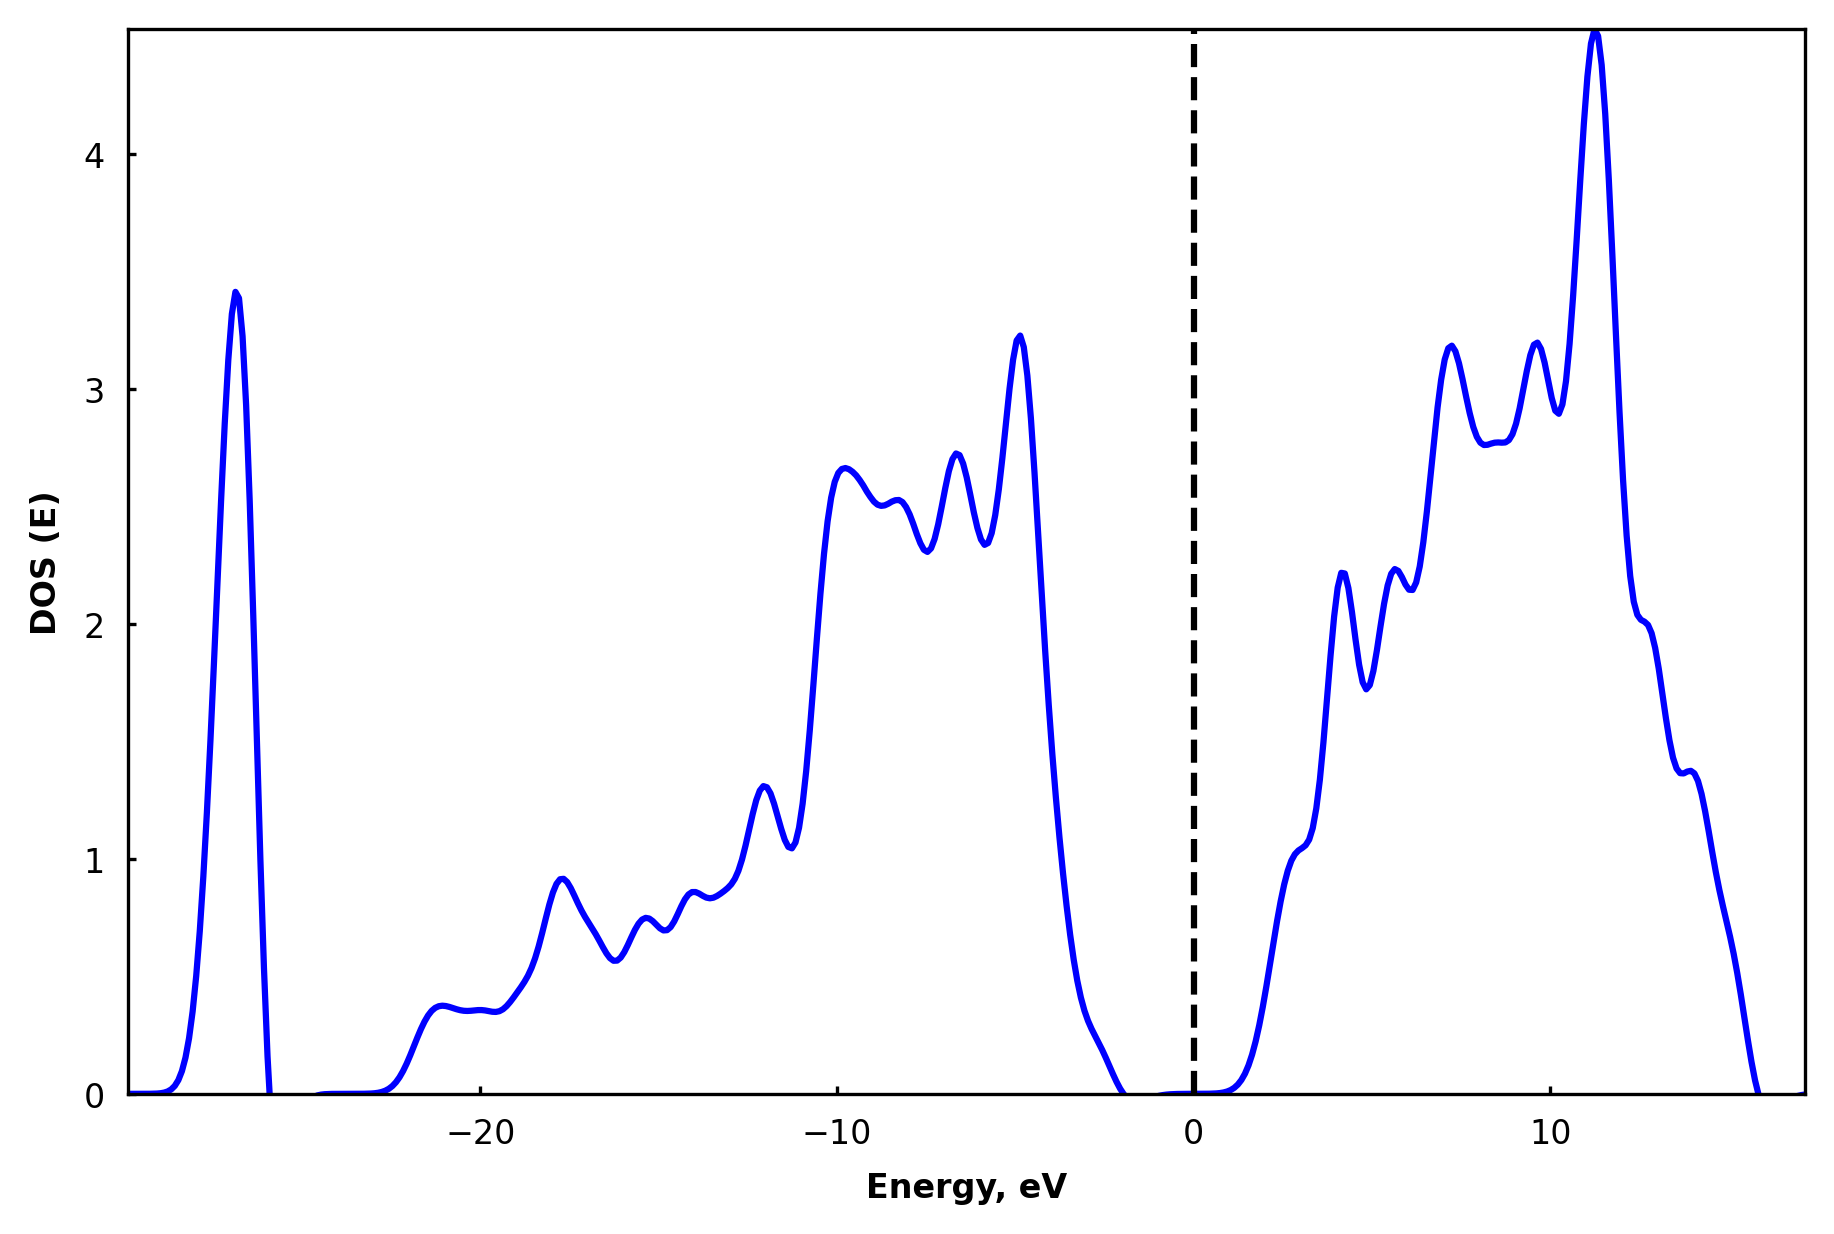

In [14]:
# Make Figure
plt.style.use('seaborn-v0_8-paper')
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300, constrained_layout=True)

ax.plot(shifted_energy, DOS_E, label='', color='blue', linewidth=1.5)
ax.set_xlabel('Energy, eV', fontsize=8, fontweight='bold', labelpad=5)
ax.set_ylabel('DOS (E)', fontsize=8, fontweight='bold', labelpad=5)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
ax.set_xlim([shifted_energy.min(), shifted_energy.max()])
ax.set_ylim([0, DOS_E.max()])
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
# ax.set_xticks(np.arange(len(kpts_grid)))
# ax.set_xticklabels(kpts_grid, rotation=60)
ax.tick_params(axis='both', which='major', labelsize=8, direction='in', length=2)
#ax.legend(loc="upper right", fontsize=8, frameon=False)

### BANDS Calculation

In [ ]:
%%writefile {general_paths[struc].electron_phonon.electron_props.__val__  / 'QE_BANDS_script.py'}

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import re
import ast
from ase.calculators.espresso import Espresso, EspressoProfile
import yaml
import pickle
import json
from munch import Munch
from yaml import CLoader as Loader
import argparse
import sys
sys.path.append("/home/heimao/Desktop/Khasan/python_files")
from util_functions import *
from pathlib import Path, PurePath

parser = argparse.ArgumentParser(description='Process input data')
parser.add_argument('--main_dir', type=str, help='Enter path to the main directory')
parser.add_argument('--struc', type=str, help='Enter structure name: (e.g. Diamane)')
parser.add_argument('--cutoff_energy', type=int)
parser.add_argument('--kpts', type=str)
parser.add_argument('--bandpath', type=str)
parser.add_argument('--special_points', type=str)
parser.add_argument('--npoints', type=int)
parser.add_argument('--nbnd', type=int)

args = parser.parse_args()
kpts = ast.literal_eval(args.kpts)
special_points = ast.literal_eval(args.special_points)

general_paths_dir = create_folder(main_dir=Path(args.main_dir), folder='utils') / 'general_paths.yaml'
if os.path.exists(general_paths_dir):
    with (general_paths_dir).open(mode='rb') as f:
        general_paths = dict_to_munch(yaml.unsafe_load(f))
        f.close()
else:
    general_paths = Munch()

print('Current directory:')
curr_dir = Path(os.getcwd())
print(curr_dir)
command = 'sh qe_run.sh'

def get_scf_params(
        command: str,
        pseudo_dir: Path,
        structure: Atoms,
        prefix: str,
        ecutwfc: float,
        kpts_grid: list,

):
    scf_params = {
        'profile': EspressoProfile(command=command, pseudo_dir=pseudo_dir),
        'input_data': {
            'control': {
                'restart_mode': 'from_scratch', # istart=0
                'calculation': 'scf', # ibrion=-1
                'prefix': prefix,
                'outdir': '.',
                'tprnfor': True,
                'tstress': True,
                'verbosity': 'high'
            },
            'system': {
                'ibrav': 0,
                'nat': structure.get_number_of_atoms(),
                'ntyp': len(set(structure.get_chemical_symbols())),
                'ecutwfc': ecutwfc,
                'ecutrho': 360.0,     # ! 4*ecutwfc = prec = 'Accurate'
                'nosym': True, # isym=0
                'occupations': 'smearing', # ismear = 0
                'smearing': 'cold', # ismear = 0
                'degauss': 0.05, # sigma = 0.05
            },
            'electrons': {
                'conv_thr': 1.0e-8,
                'mixing_beta': 0.7,
            },
            'ions': {
                'ion_dynamics': 'bfgs'
            }
        },
        'kpts': kpts_grid,
        'pseudopotentials': {
            'C': 'C.pbesol-n-kjpaw_psl.1.0.0.UPF',
            'F': 'F.pbesol-n-kjpaw_psl.1.0.0.UPF'}
    }
    return scf_params

def get_bands_params(
        command: str,
        pseudo_dir: Path,
        structure: Atoms,
        prefix: str,
        ecutwfc: float,
        kpts_grid: list,
        nbnd: int,

):
    bands_params = {
        'profile': EspressoProfile(command=command, pseudo_dir=pseudo_dir),
        'input_data': {
            'control': {
                #'restart_mode': 'from_scratch', # istart=0
                'calculation': 'bands',
                'prefix': prefix,
                'outdir': '.',
                'tprnfor': True,
                'tstress': True,
                'verbosity': 'high'
            },
            'system': {
                'ibrav': 0,
                'nat': structure.get_number_of_atoms(),
                'ntyp': len(set(structure.get_chemical_symbols())),
                'nbnd': nbnd, # Correctly choose value
                'ecutwfc': ecutwfc,
                'ecutrho': 360.0,     # ! 4*ecutwfc
                'nosym': True,
                'occupations': 'smearing',
                'smearing': 'cold',
                'degauss': 0.05,
            },
        },
        'kpts': kpts_grid,
        'pseudopotentials': {
            'C': 'C.pbesol-n-kjpaw_psl.1.0.0.UPF',
            'F': 'F.pbesol-n-kjpaw_psl.1.0.0.UPF'}
    }
    return bands_params

if __name__ == '__main__':

    folder_name = create_folder(main_dir=general_paths[args.struc].electron_phonon.electron_props.__val__, folder='BANDS')
    structure = read(general_paths.utils.__val__ / 'POSCAR')
    path = structure.cell.bandpath(path=args.bandpath, special_points=special_points, npoints=args.npoints)

    os.system(f'cp {general_paths[args.struc].electron_phonon.__val__ / "qe_run.sh"} {folder_name}')
    os.chdir(folder_name)
    # Create dos file
    create_bands_in(
        main_dir=folder_name / 'bands.in',
        prefix=args.struc,
    )
    # SCF
    scf_params = get_scf_params(
        command=command,
        pseudo_dir=general_paths.utils.__val__,
        structure=structure,
        prefix=args.struc,
        ecutwfc=args.cutoff_energy,
        kpts_grid=kpts,
    )
    calc = Espresso(**scf_params)
    structure.calc = calc
    structure.get_potential_energy()
    print(f'\nSCF finished successfully\n')

    # BANDS
    bands_params = get_bands_params(
        command=command,
        pseudo_dir=general_paths.utils.__val__,
        structure=structure,
        prefix=args.struc,
        ecutwfc=args.cutoff_energy,
        kpts_grid=np.hstack((path.kpts, np.ones((path.kpts.shape[0], 1)))),
        nbnd=args.nbnd,
    )
    calc = Espresso(**bands_params)
    structure.calc = calc
    structure.get_potential_energy()
    print(f'\nNSCF finished successfully\n')

Writing /home/heimao/Desktop/Khasan/Lab_works/Diamane/2.Electron_Phonon_props/2.1.Electron_props/QE_BANDS_script.py


In [ ]:
# Choose optimal cut-off energy
cutoff_energy = 45
# Choose optimal kpoints grid
kpts_vals = [12, 12, 1]

nbnd = 30 # CHANGE
bandpath = 'GMKG' # CHANGE
special_points={                                       # CHANGE
    'G': [0.0000000000, 0.0000000000, 0.0000000000], 
    'M': [0.5000000000, 0.5000000000, 0.0000000000], 
    'K': [0.6666666666, 0.3333333333, 0.0000000000]
    }
npoints = (len(bandpath)-1) * 50

create_bash_script(
script_filename=general_paths[struc].electron_phonon.electron_props.__val__ / 'bands_script.sh',
job_name='qe-bands',
partition='cpu',
nodes=1,
memory='6G',
exclude='',
ntasks=20,
cpus_per_task=1,
gpus=0,
time=72,
command=f'python QE_BANDS_script.py \
    --struc={struc} \
    --main_dir={main_dir} \
    --cutoff_energy="{cutoff_energy}" \
    --kpts="{str(kpts_vals)}" \
    --bandpath="{bandpath}" \
    --special_points="{str(special_points)}" \
    --npoints={npoints} \
    --nbnd={nbnd}'
)

> **RUN CALCULATIONS** <br>

`sbatch bands_script.sh`

In [ ]:
create_bash_script(
    script_filename=general_paths[struc].electron_phonon.electron_props.__val__ / 'BANDS' / 'bands_in_script.sh',
    job_name='qe-bands',
    partition='cpu',
    nodes=1,
    memory='6G',
    exclude='',
    ntasks=20,
    cpus_per_task=1,
    gpus=0,
    time=72,
    command='mpirun -n 20 bands.x < bands.in > bands.out'
)

> **RUN CALCULATIONS** <br>

`sbatch bands_in_script.sh`

### BANDS Visualisation

In [81]:
# Obtain energy and distances
hspoints, bandEnergy = bands_vals(
    work_dir=general_paths[struc].electron_phonon.electron_props.__val__ / 'BANDS' / 'bands.out.gnu',
)

# Obtain distance for High Symmetry Points (HSP)
structure = read(general_paths.utils.__val__ / 'POSCAR')
path = structure.cell.bandpath(path=bandpath, special_points=special_points, npoints=npoints)
hsp_dist = find_dist_for_hsp(
    bandpath=bandpath,
    special_points=special_points,
    path_kpts=path.kpts,
    hspoints=hspoints.reshape(nbnd, npoints)[0]
)

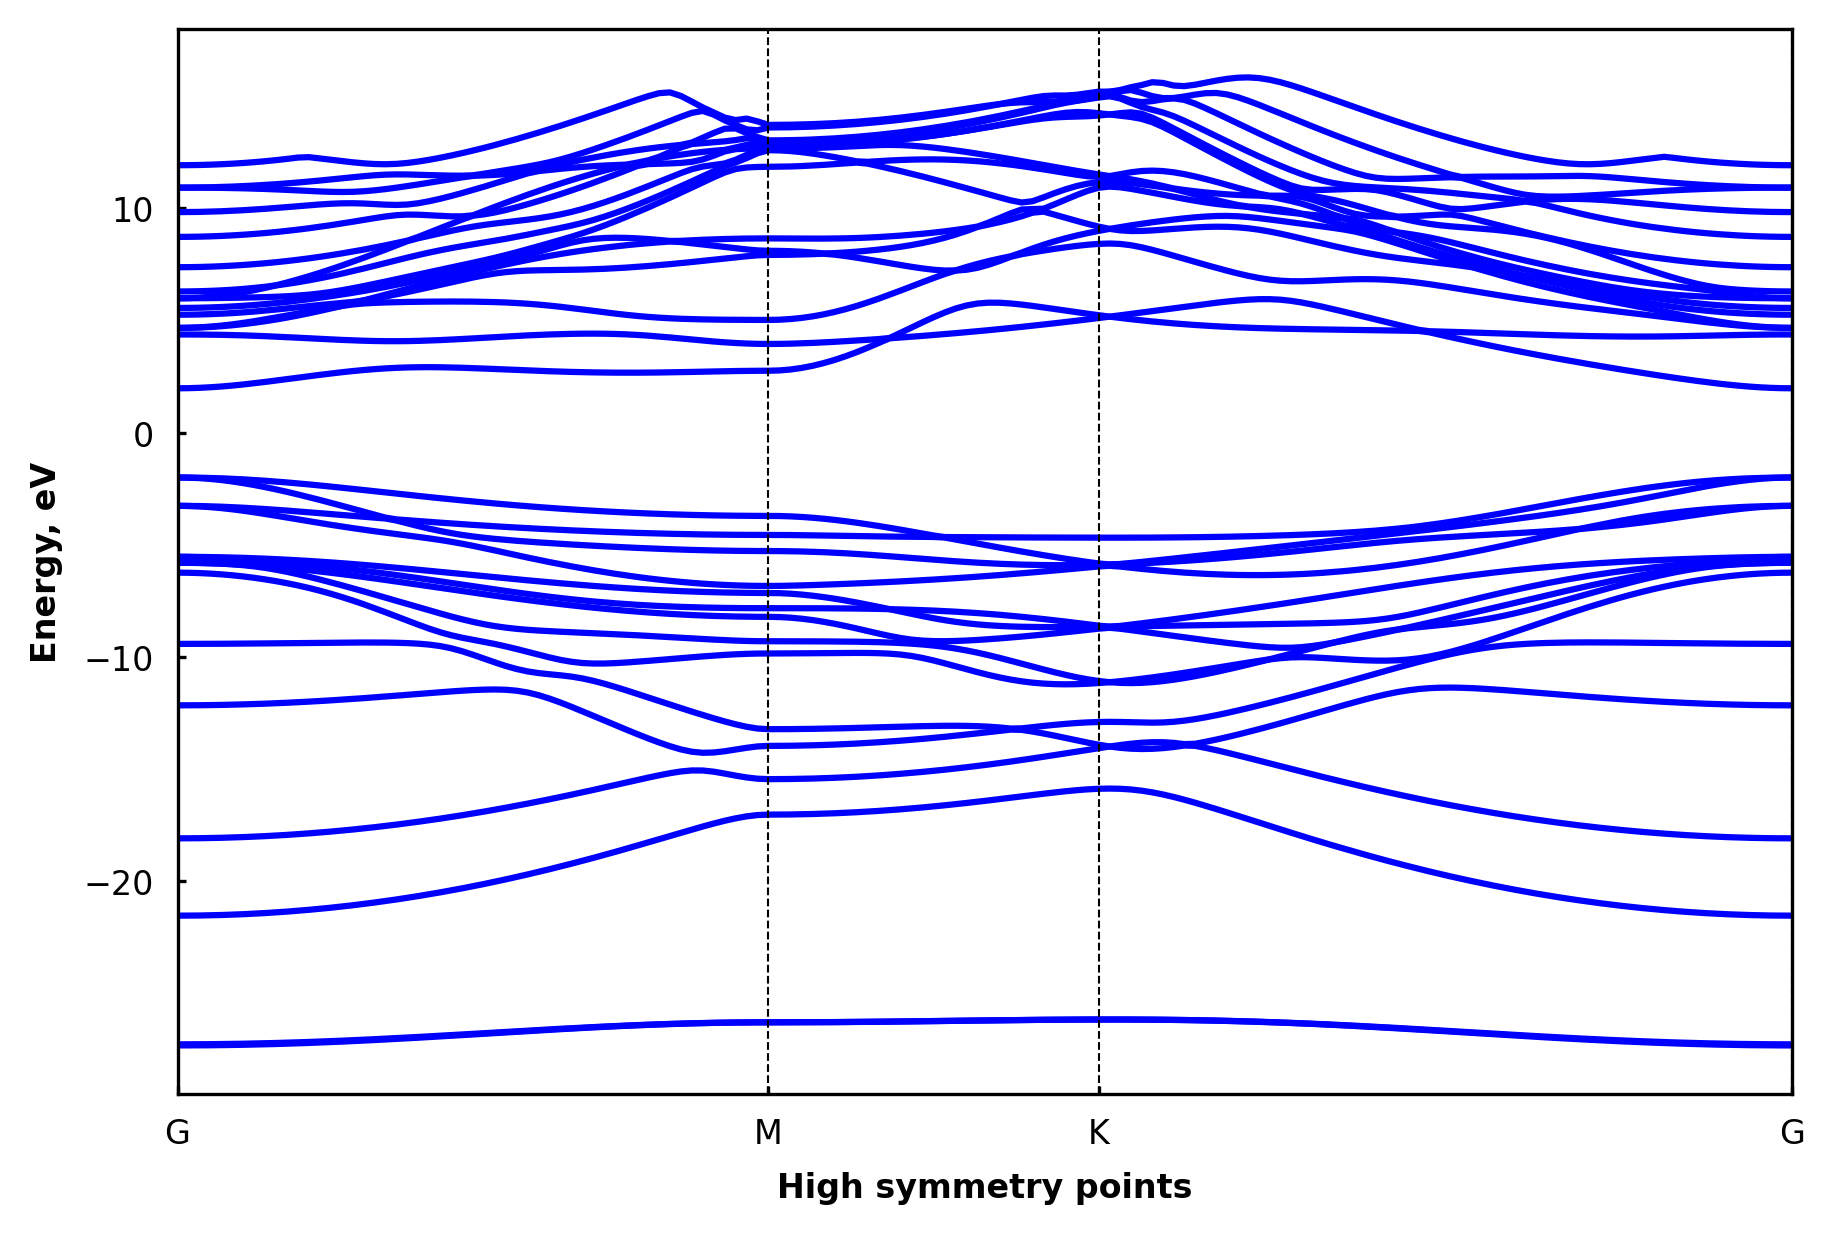

In [84]:
# Make Figure
plt.style.use('seaborn-v0_8-paper')
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300, constrained_layout=True)

for x, y in zip(hspoints.reshape(nbnd, npoints), bandEnergy.reshape(nbnd, npoints)):
    ax.plot(x, y, label='', color='blue', linewidth=1.5)
ax.set_xlabel('High symmetry points', fontsize=8, fontweight='bold', labelpad=5)
ax.set_ylabel('Energy, eV', fontsize=8, fontweight='bold', labelpad=5)
for dist in hsp_dist:
    ax.axvline(x=dist, color='black', linestyle='--', linewidth=0.5)
ax.set_xlim([hsp_dist[0], hsp_dist[-1]])
# ax.set_ylim([0, DOS_E.max()])
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticks(hsp_dist)
ax.set_xticklabels(list(bandpath))
ax.tick_params(axis='both', which='major', labelsize=8, direction='in', length=2)
#ax.legend(loc="upper right", fontsize=8, frameon=False)

## PART 2.2 - Phonon properties

### **General Workflow**
✅ 5) **Implement SCF calculation and obtain phonon DOS & BANDS**
- Please, fill the function **get_scf_params** by parameters for your structure.

> **IMPORTANT** Please, copy SCF parameters from the previous lab with optimized **cutoff_energy** and **kpts** in the cell below. <br>

- After implementation above steps, please, run the cells in the part *SCF Calculation* and go to the working directory in the **Terminal**: <br>

📝 Desktop/*your_name*/Lab_works/*struc*/2.Electron_Phonon_props/2.2.Phonon_props <br>

🌟Run calculations: 
**sbatch dos_script.sh** <br>
If calculations successfully finished, you will see the note **JOB DONE** in the **espresso.pwo** files. If it is done, you can go to the next step.

-  Also, you need to fulfill parameters: **bandpath**, **special_points** according to the previous electronic BANDS calculations.

- Please, run the cells in the part *DOS Calculation* and then go to the working directory in the **Terminal**: <br>

📝 Desktop/*your_name*/Lab_works/*struc*/2.Electron_Phonon_props/2.1.Electron_props/DOS <br>

- You can find the next files in the current directory and the desciption of them is available by attached links:

To fill next input files, please, read a documentation: <br>
✔ ***your_struc*_ph.in** <br>
https://www.quantum-espresso.org/Doc/INPUT_PH.html <br>
🎯Purpose of **ph.x**: <br>
It solves the Density Functional Perturbation Theory (DFPT) problem. <br>
It constructs a dynamic matrix based on the given q-points in the knowledge base. <br>

✔ ***your_struc*_q2r.in** <br>
https://www.quantum-espresso.org/Doc/INPUT_Q2R.html <br>
🎯Purpose of **q2r.x**: <br>
It reads force constant matrices C(q) produced by the ph.x code <br>
for a grid of q-points and calculates the corresponding set <br>
of interatomic force constants <br>

✔ ***your_struc*_matdyn.in** <br>
https://www.quantum-espresso.org/Doc/INPUT_MATDYN.html <br>
🎯Purpose of **matdyn.x**: <br>
This program calculates the phonon frequencies for a list of generic <br>
q vectors starting from the interatomic force constants generated <br>
from the dynamical matrices as written by DFPT phonon code through <br>
the companion program **q2r.x** <br>

Run calculations in the terminal step by step, but **DO NOT** run all together: <br>

🌟Run calculations: 
**sbatch ph_in_script.sh** <br>
If calculations successfully finished, you will see the note **JOB DONE** in the ***your_struc*_ph.out** files

🌟Run calculations:
**sbatch q2r_in_script.sh** <br>
If calculations successfully finished, you will see the note **JOB DONE** in the ***your_struc*_q2r.out** files

🌟Run calculations:
**sbatch matdyn_script.sh** <br>
If calculations successfully finished, you will see the note **JOB DONE** in the ***your_struc*_matdyn_DOS.out** files


- In the visualisation part, you need run cells and obtain the figure. This figure must be used in your **Lab Report**


### SCF Calculation

In [28]:
%%writefile {general_paths[struc].electron_phonon.phonon_props.__val__  / 'QE_DOS_script.py'}

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import re
import ast
from ase.calculators.espresso import Espresso, EspressoProfile
import yaml
import pickle
import json
from munch import Munch
from yaml import CLoader as Loader
import argparse
import sys
sys.path.append("/home/heimao/Desktop/Khasan/python_files")
from util_functions import *
from pathlib import Path, PurePath

parser = argparse.ArgumentParser(description='Process input data')
parser.add_argument('--main_dir', type=str, help='Enter path to the main directory')
parser.add_argument('--struc', type=str, help='Enter structure name: (e.g. Diamane)')
parser.add_argument('--cutoff_energy', type=int)
parser.add_argument('--kpts', type=str)
args = parser.parse_args()

kpts = ast.literal_eval(args.kpts)

general_paths_dir = create_folder(main_dir=Path(args.main_dir), folder='utils') / 'general_paths.yaml'
if os.path.exists(general_paths_dir):
    with (general_paths_dir).open(mode='rb') as f:
        general_paths = dict_to_munch(yaml.unsafe_load(f))
        f.close()
else:
    general_paths = Munch()

print('Current directory:')
curr_dir = Path(os.getcwd())
print(curr_dir)
command = 'sh qe_run.sh'

def get_scf_params(
        command: str,
        pseudo_dir: Path,
        structure: Atoms,
        prefix: str,
        ecutwfc: float,
        kpts_grid: list,

):
    scf_params = {
        'profile': EspressoProfile(command=command, pseudo_dir=pseudo_dir),
        'input_data': {
            'control': {
                'restart_mode': 'from_scratch', # istart=0
                'calculation': 'scf', # ibrion=-1
                'prefix': prefix,
                'outdir': '.',
                'tprnfor': True,
                'tstress': True,
                'verbosity': 'high'
            },
            'system': {
                'ibrav': 0,
                'nat': structure.get_number_of_atoms(),
                'ntyp': len(set(structure.get_chemical_symbols())),
                'ecutwfc': ecutwfc,
                'ecutrho': 360.0,     # ! 4*ecutwfc = prec = 'Accurate'
                'nosym': True, # isym=0
                'occupations': 'smearing', # ismear = 0
                'smearing': 'cold', # ismear = 0
                'degauss': 0.05, # sigma = 0.05
            },
            'electrons': {
                'conv_thr': 1.0e-8,
                'mixing_beta': 0.7,
            },
            'ions': {
                'ion_dynamics': 'bfgs'
            }
        },
        'kpts': kpts_grid,
        'pseudopotentials': {
            'C': 'C.pbesol-n-kjpaw_psl.1.0.0.UPF',
            'F': 'F.pbesol-n-kjpaw_psl.1.0.0.UPF'}
    }
    return scf_params

if __name__ == '__main__':

    folder_name = create_folder(main_dir=general_paths[args.struc].electron_phonon.phonon_props.__val__, folder='DOS')
    structure = read(general_paths.utils.__val__ / 'POSCAR')

    os.system(f'cp {general_paths[args.struc].electron_phonon.__val__ / "qe_run.sh"} {folder_name}')
    os.chdir(folder_name)
    # Create dos file
    create_dos_in(
        main_dir=folder_name / 'dos.in',
        prefix=args.struc,
        deltaE=0.1,
    )
    # SCF
    scf_params = get_scf_params(
        command=command,
        pseudo_dir=general_paths.utils.__val__,
        structure=structure,
        prefix=args.struc,
        ecutwfc=args.cutoff_energy,
        kpts_grid=kpts,
    )
    calc = Espresso(**scf_params)
    structure.calc = calc
    structure.get_potential_energy()
    print(f'\nSCF finished successfully\n')

Overwriting /home/heimao/Desktop/Khasan/Lab_works/Diamane/2.Electron_Phonon_props/2.2.Phonon_props/QE_DOS_script.py


In [ ]:
# Choose optimal cut-off energy
cutoff_energy = 45
# Choose optimal kpoints grid
kpts_vals = [12, 12, 2]

create_bash_script(
script_filename=general_paths[struc].electron_phonon.phonon_props.__val__ / 'dos_script.sh',
job_name='qe-dos',
partition='cpu',
nodes=1,
memory='6G',
exclude='',
ntasks=20,
cpus_per_task=1,
gpus=0,
time=72,
command=f'python QE_DOS_script.py \
    --struc={struc} \
    --main_dir={main_dir} \
    --cutoff_energy="{cutoff_energy}" \
    --kpts="{str(kpts_vals)}"'
)

> **RUN CALCULATIONS** <br>

`sbatch dos_script.sh`

### DOS Calculation

In [ ]:
bandpath = 'GMKG'
special_points={
    'G': [0.0000000000, 0.0000000000, 0.0000000000], 
    'M': [0.5000000000, 0.5000000000, 0.0000000000], 
    'K': [0.6666666666, 0.3333333333, 0.0000000000]
    }

nkpts = 100
hsp_kpts = []
for i, letter in enumerate(bandpath):
    hsp_kpts.append(special_points[letter].copy())
    hsp_kpts[-1].append(nkpts)

structure = read(general_paths.utils.__val__ / 'POSCAR')

create_phdos_files(
    main_dir=general_paths[struc].electron_phonon.phonon_props.__val__ / 'DOS',
    struc=struc,
    amass=set(structure.get_masses()),
    nq=kpts_vals,
    zasr='crystal',
    nk=[nkpts, nkpts, nkpts],
    epsil='.false.',
    raman_spec='.false.',
    IR_spec='.false.',
    hsp_kpts=hsp_kpts
)

In [ ]:
create_bash_script(
    script_filename=general_paths[struc].electron_phonon.phonon_props.__val__ / 'DOS' / 'ph_in_script.sh',
    job_name='qe-ph',
    partition='cpu',
    nodes=1,
    memory='6G',
    exclude='',
    ntasks=20,
    cpus_per_task=1,
    gpus=0,
    time=72,
    command=f'mpirun -n 20 ph.x < {struc}_ph.in > {struc}_ph.out'
)

> **RUN CALCULATIONS** <br>

`sbatch ph_in_script.sh`

In [ ]:
create_bash_script(
    script_filename=general_paths[struc].electron_phonon.phonon_props.__val__ / 'DOS' / 'q2r_in_script.sh',
    job_name='qe-ph',
    partition='cpu',
    nodes=1,
    memory='6G',
    exclude='',
    ntasks=1,
    cpus_per_task=1,
    gpus=0,
    time=72,
    command=f'q2r.x < {struc}_q2r.in > {struc}_q2r.out'
)

> **RUN CALCULATIONS** <br>

`sbatch q2r_in_script.sh`

In [ ]:
create_bash_script(
    script_filename=general_paths[struc].electron_phonon.phonon_props.__val__ / 'DOS' / 'matdyn_script.sh',
    job_name='qe-ph',
    partition='cpu',
    nodes=1,
    memory='6G',
    exclude='',
    ntasks=20,
    cpus_per_task=1,
    gpus=0,
    time=72,
    command=f'mpirun -n 20 matdyn.x < {struc}_matdyn_DOS.in > {struc}_matdyn_DOS.out'
)

> **RUN CALCULATIONS** <br>

`sbatch matdyn_script.sh`